In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense,Dropout,Flatten
from keras.optimizers import adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input   #specific to mobilenet [-1,1] limit
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix,f1_score
import itertools
import matplotlib.pyplot as plt
import cv2
%matplotlib inline



# preprocessing_function: function that will be implied on each input. 
# The function will run after the image is resized and augmented.
# The function should take one argument: one image (Numpy tensor with rank 3),
# and should output a Numpy tensor with the same shape.  # preprocess_input similar to to_tensor in pytorch
#preprocess input normalization depend on structure of network pulled in

Using TensorFlow backend.


# preprocess image first time after download from Kaggle

In [2]:

# %cd ~/Downloads/Sign-Language-Digits-Dataset/Dataset

# %mkdir train
# %mkdir test
# %mkdir eval

# %mv 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/ train

# %cd eval
# %mkdir 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/

# %cd ../test
# %mkdir 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/

# %%bash
# cd ../train
# for ((i=0; i<=9; i++)); do
#     a=$(find $i/ -type f | shuf -n 30)
#     mv $a ../eval/$i/
#     b=$(find $i/ -type f | shuf -n 10)
#     mv $b ../test/$i/    
# done

# %cd ../..

In [3]:

train_dir='/home/paperspace/project/Sign-Language-Dataset/train/'
eval_dir='/home/paperspace/project/Sign-Language-Dataset/eval/'
test_dir='/home/paperspace/project/Sign-Language-Dataset/test/'

In [4]:
train_batch_gen=ImageDataGenerator(rotation_range=5,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  shear_range=0.05,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  preprocessing_function=preprocess_input).flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    classes=['0','1','2','3','4','5','6','7','8','9'])

test_batch_gen=ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=10,
    classes=['0','1','2','3','4','5','6','7','8','9'],shuffle=False)  


eval_batch_gen=ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    eval_dir,
    target_size=(224,224),
    batch_size=10,
    classes=['0','1','2','3','4','5','6','7','8','9']) #can also do class_mode='binary' # seems by putting cat first is consider that [1,0] and dog is [0,1]


Found 1662 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [5]:
imgs,labels=next(train_batch_gen)
def visualize(img,ax):
    #img=cv2.imread(path)
    #mg=image.load_img(img)
    ax.imshow((img/2.0)+0.5,vmin=0.0,vmax=1.0) #images are -1 and 1 limit from generator for mobile net, need to
def plot_image_matrix(imgs,labels):         # make it between 0 and 1 and clip to make sure no issue for plotting

    plt.figure(figsize=(20,15))
    for i in range(len(labels)):
        ax=plt.subplot(8,len(labels)//8,i+1,xticks=[],yticks=[])
        visualize(imgs[i],ax)
        ax.set_title(labels[i])    

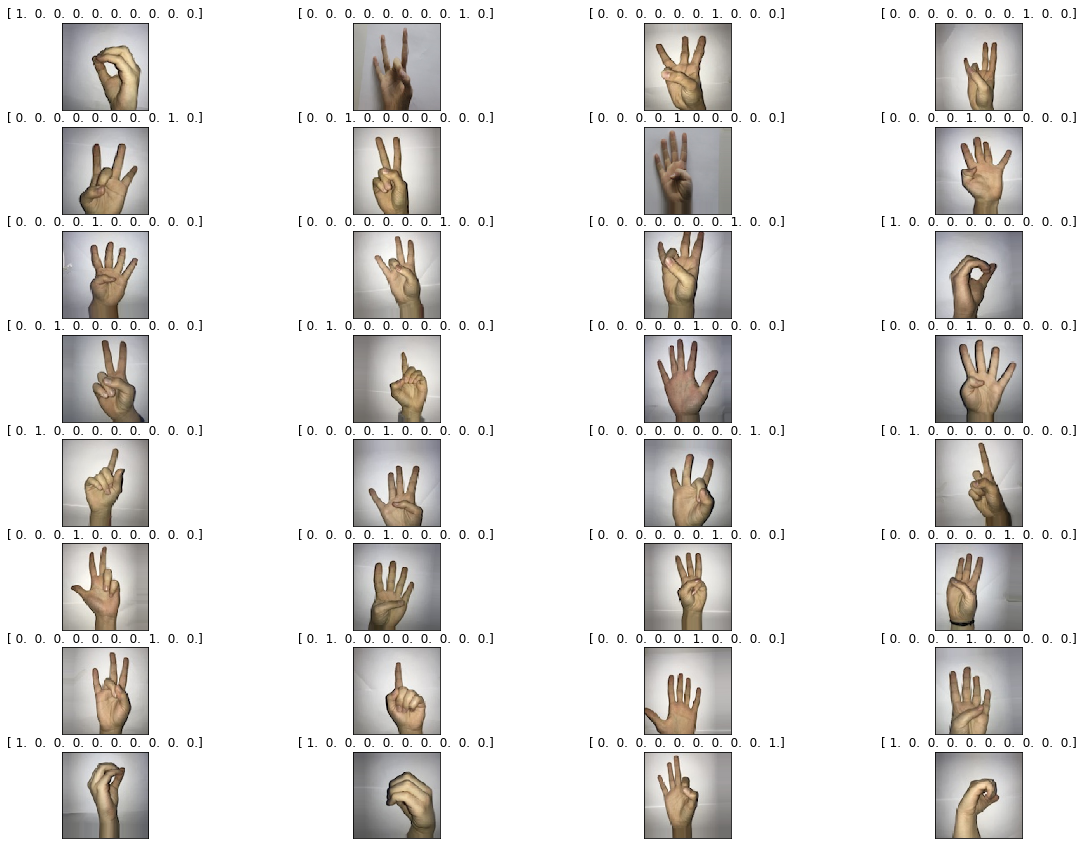

In [6]:
plot_image_matrix(imgs,labels)

In [7]:
mobile_net=keras.applications.mobilenet.MobileNet()

In [8]:
mobile_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [9]:
mobile_net.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [10]:
mobile_net.output

<tf.Tensor 'reshape_2/Reshape:0' shape=(?, 1000) dtype=float32>

In [11]:
mobile_net.layers[-6]

In [12]:
x=mobile_net.layers[-6].output  #don't need to put start to beginning up to and including global pooling layer

In [13]:
predictions=Dense(10,activation='softmax')(x)  #don;t need to put add
mobile_net_new=Model(inputs=mobile_net.input,outputs=predictions) #get input and output and everythong in between !
#functional API, keras retrieve every layer involved from input to output, brining them in  agraph like structure
#this work since output was obtained by repeatabily transforming input tensor
#if input and out put tensors are nopt related you get Rutn-timeError

In [14]:
mobile_net_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [15]:
for layer in mobile_net_new.layers:
    print(layer.name,layer.trainable)

input_1 False
conv1_pad True
conv1 True
conv1_bn True
conv1_relu True
conv_dw_1 True
conv_dw_1_bn True
conv_dw_1_relu True
conv_pw_1 True
conv_pw_1_bn True
conv_pw_1_relu True
conv_pad_2 True
conv_dw_2 True
conv_dw_2_bn True
conv_dw_2_relu True
conv_pw_2 True
conv_pw_2_bn True
conv_pw_2_relu True
conv_dw_3 True
conv_dw_3_bn True
conv_dw_3_relu True
conv_pw_3 True
conv_pw_3_bn True
conv_pw_3_relu True
conv_pad_4 True
conv_dw_4 True
conv_dw_4_bn True
conv_dw_4_relu True
conv_pw_4 True
conv_pw_4_bn True
conv_pw_4_relu True
conv_dw_5 True
conv_dw_5_bn True
conv_dw_5_relu True
conv_pw_5 True
conv_pw_5_bn True
conv_pw_5_relu True
conv_pad_6 True
conv_dw_6 True
conv_dw_6_bn True
conv_dw_6_relu True
conv_pw_6 True
conv_pw_6_bn True
conv_pw_6_relu True
conv_dw_7 True
conv_dw_7_bn True
conv_dw_7_relu True
conv_pw_7 True
conv_pw_7_bn True
conv_pw_7_relu True
conv_dw_8 True
conv_dw_8_bn True
conv_dw_8_relu True
conv_pw_8 True
conv_pw_8_bn True
conv_pw_8_relu True
conv_dw_9 True
conv_dw_9_bn True
c

In [16]:
for layer in mobile_net_new.layers[:-23]:  #keep last convolutional layer and dense to be trainable
    layer.trainable=False
    

In [17]:
for layer in mobile_net_new.layers:
    print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False


# train mobile_net fine-tunned 

In [18]:
mobile_net_new.compile(optimizer=adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
from  keras.callbacks  import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='mobile_net_sign_best.hdf5', verbose=1,save_best_only=True,save_weights_only=False)

# history=model.fit_generator(train_batch_gen,steps_per_epoch=70//5,epochs=20,
#                     validation_data=eval_batch_gen,validation_steps=20//5,verbose=2)  #
#70 sample size, 10 batch size, 7 times to go through a train data in one epoch

history=mobile_net_new.fit_generator(train_batch_gen,epochs=30,steps_per_epoch=train_batch_gen.samples//32,
                    validation_data=eval_batch_gen,validation_steps=eval_batch_gen.samples//10,verbose=2,callbacks=[checkpointer])

#is a restart run

Epoch 1/30
 - 20s - loss: 1.3310 - acc: 0.5830 - val_loss: 1.6272 - val_acc: 0.4533

Epoch 00001: val_loss improved from inf to 1.62717, saving model to mobile_net_sign_best.hdf5
Epoch 2/30
 - 19s - loss: 0.4265 - acc: 0.8970 - val_loss: 1.1943 - val_acc: 0.6533

Epoch 00002: val_loss improved from 1.62717 to 1.19435, saving model to mobile_net_sign_best.hdf5
Epoch 3/30
 - 19s - loss: 0.2428 - acc: 0.9472 - val_loss: 1.0143 - val_acc: 0.7000

Epoch 00003: val_loss improved from 1.19435 to 1.01430, saving model to mobile_net_sign_best.hdf5
Epoch 4/30
 - 18s - loss: 0.1668 - acc: 0.9699 - val_loss: 0.8482 - val_acc: 0.7367

Epoch 00004: val_loss improved from 1.01430 to 0.84816, saving model to mobile_net_sign_best.hdf5
Epoch 5/30
 - 18s - loss: 0.1292 - acc: 0.9785 - val_loss: 0.6753 - val_acc: 0.8233

Epoch 00005: val_loss improved from 0.84816 to 0.67534, saving model to mobile_net_sign_best.hdf5
Epoch 6/30
 - 18s - loss: 0.1045 - acc: 0.9785 - val_loss: 0.6989 - val_acc: 0.7900

Epoc

In [20]:
from keras.models import load_model
mobile_net_new.save('mobile_net_sign_last.hdf5')

model_test=load_model('mobile_net_sign_last.hdf5')  #no error

In [21]:
model_test2=load_model('mobile_net_sign_best.hdf5')

In [22]:
test_batch_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

In [24]:
#running last instance
prediction=mobile_net_new.predict_generator(test_batch_gen,steps=10,verbose=1)
test_labels_round=test_batch_gen.classes
predictions_round=np.argmax(prediction,axis=1)
np.mean(test_labels_round==predictions_round)  

10/10 [==============================] - 1s 100ms/step


0.90000000000000002

In [25]:
#using best
prediction=model_test2.predict_generator(test_batch_gen,steps=10,verbose=1)
test_labels_round=test_batch_gen.classes
predictions_round=np.argmax(prediction,axis=1)
np.mean(test_labels_round==predictions_round)  

10/10 [==============================] - 1s 107ms/step


0.93000000000000005

In [26]:
#running last instance
prediction=model_test.predict_generator(test_batch_gen,steps=10,verbose=1)
test_labels_round=test_batch_gen.classes
predictions_round=np.argmax(prediction,axis=1)
np.mean(test_labels_round==predictions_round)   #best is better than last step !

10/10 [==============================] - 1s 94ms/step


0.90000000000000002

In [27]:
test_loss,test_acc=mobile_net_new.evaluate_generator(test_batch_gen,steps=10)
print('test_accuracy',test_acc)   #bingo got simiar to np.mean()
eval_loss,eval_acc=mobile_net_new.evaluate_generator(eval_batch_gen,steps=30)
print('eval_accuracy',eval_acc)
train_loss,train_acc=mobile_net_new.evaluate_generator(train_batch_gen,steps=52)
print('train_accuracy',train_acc)

test_accuracy 0.9
eval_accuracy 0.883333323399
train_accuracy 0.912154030786


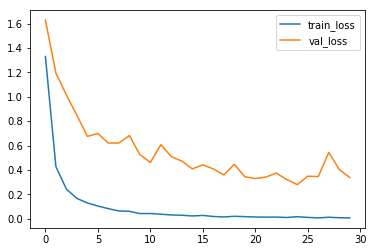

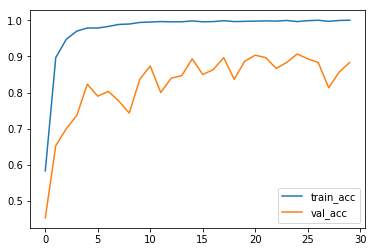

In [28]:

history_dic=history.history
import matplotlib.pyplot as plt
list_epoch=np.arange(0,30)
plt.plot(list_epoch,history_dic['loss'])

plt.plot(list_epoch,history_dic['val_loss'])

plt.legend(['train_loss','val_loss'])
plt.show()

list_epoch=np.arange(0,30)

plt.plot(list_epoch,history_dic['acc'])

plt.plot(list_epoch,history_dic['val_acc'])
plt.legend(['train_acc','val_acc'])
plt.show()

In [29]:
cm=confusion_matrix(predictions_round,test_labels_round)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  3  0  0]
 [ 0  0  0 10  0  0  0  1  0  1]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  4  0 10  0  1  0]
 [ 0  0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  9]]


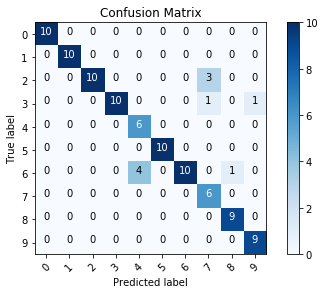

In [31]:
#if argmax=0 'cat' [1,0], if argmax=1 'dog' [0,1]
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [74]:
imgs,labels=next(train_batch_gen)
print(len(labels))
def visualize(img,ax):
    #img=cv2.imread(path)
    #mg=image.load_img(img)
    ax.imshow((img/2.0)+0.5,vmin=0.0,vmax=1.0) #images are -1 and 1 limit from generator for mobile net, need to
def plot_image_matrix(imgs,labels):         # make it between 0 and 1 and clip to make sure no issue for plotting

    plt.figure(figsize=(20,20))
    for i in range(len(labels)):
        ax=plt.subplot(8,len(labels)//4,i+1,xticks=[],yticks=[])
        visualize(imgs[i],ax)
        predict=mobile_net_new.predict(np.expand_dims(imgs[i],axis=0))
        
        text='Actual: '+str(np.argmax(labels[i]))+'  Predict: '+str(np.argmax(predict,axis=1)[0])
        if (int(np.argmax(labels[i]))==int(np.argmax(predict,axis=1)[0])):
            color_='green'
        else:
            color_='red'
        ax.set_title(text,color=color_,fontweight='bold')    

32


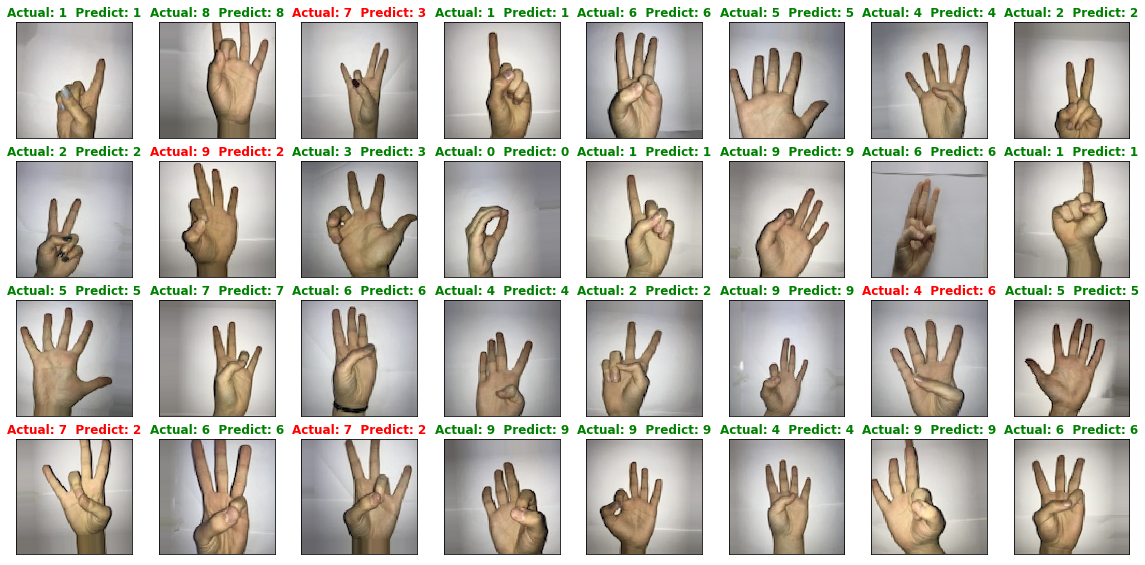

In [75]:
plot_image_matrix(imgs,labels)